# Unified Model with Multiple Strategic Agents

### Asymmetric Double Stochastic Matrix

James Yu, 11 July 2025

In [1]:
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np

np.set_printoptions(suppress=True)

In [2]:
def M(K, B, R, L, delta):
    """Computes M_{t-1} given B_l \forall l, K_t^l \forall l, 
        R_l \forall l, number of strategic agents L, and delta."""
    # handle the generic structure first, with the correct pairings:
    base = [[B[l_prime].T @ K[l_prime] @ B[l] for l in range(L)] for l_prime in range(L)]
    # then change the diagonals to construct M_{t-1}:
    for l in range(L): base[l][l] = B[l].T @ K[l] @ B[l] + R[l]/delta
    return np.block(base)

def H(B, K, A, L):
    """Computes H_{t-1} given B_l \forall l, K_t^l \forall l, 
        A, and number of strategic agents L."""
    return np.concatenate(tuple(B[l].T @ K[l] @ A for l in range(L)), axis = 0)

def C_l(A, B, K, k, h, L, c, x, n):
    """Computes C_{t-1}^h (displayed as C_{t-1}^l) given A, B_l \forall l, K_t^l \forall l, 
        k_t^l \forall l, a specific naive agent h, number of strategic agents L, 
        c_l \forall l, x_l \forall l, and number of naive agents n"""
    return np.concatenate(tuple(B[l].T @ K[l] @ A @ ((x[h] - x[l]) * np.ones((n, 1))) 
                           + B[l].T @ K[l] @ c[l] 
                           + 0.5 * B[l].T @ k[l].T for l in range(L)), axis = 0)

def E(M_, H_):
    """Computes the generic E_{t-1} given M_{t-1} and H_{t-1}."""
    return np.linalg.inv(M_) @ H_

def F(M_, C_l_, l, n):
    """Computes F_{t-1}^l given M_{t-1}, C_{t-1}^l, 
       specific naive agent l and number of naive agents n."""
    return (np.linalg.inv(M_) @ C_l_)[l*n:(l+1)*n, :] # e.g. l = 0 gives ln = 0, l = 1 gives ln = n, etc

def G(A, B, E_, L, n):
    """Computes the generic G_{t-1} given A, B_l \forall l, 
        E_{t-1}, number of strategic agents L, and number of naive agents n."""
    return A - sum([B[l] @ E_[l*n:(l+1)*n, :] for l in range(L)])
    
def g_l(B, E_, h, x, F_, L, n, c):
    """Computes g_{t-1}^l given B_l \forall l, E_{t-1}^l, 
        a particular naive agent h, x_l \forall l, F_{t-1}^l \forall l, 
        number of strategic agents L, number of naive agents n, and c_h."""
    return - sum([B[l] @ (E_[l*n:(l+1)*n, :] @ ((x[h] - x[l]) * np.ones((n, 1))) + F_[l]) for l in range(L)]) + c[h]

In [3]:
def K_t_minus_1(Q, K, E_, R, G_, L, delta, n):
    return [Q[l] + E_[l*n:(l+1)*n, :].T @ R[l] @ E_[l*n:(l+1)*n, :] 
            + delta * G_.T @ K[l] @ G_ for l in range(L)]

def k_t_minus_1(K, k, G_, g, E_, F_, R, L, delta, n):
    return [2*delta* g[l].T @ K[l] @ G_ + delta * k[l] @ G_ 
            + 2 * F_[l].T @ R[l] @ E_[l*n:(l+1)*n, :] for l in range(L)]

def kappa_t_minus_1(K, k, kappa, g_, F_, R, L, delta):            
    return [-delta * (g_[l].T @ K[l] @ g_[l] + k[l] @ g_[l] - kappa[l]) 
            - (F_[l].T @ R[l] @ F_[l]) for l in range(L)]

In [4]:
def solve(K_t, k_t, kappa_t, A, B, delta, n, L, Q, R, x, c, tol = 300):
    historical_K = [K_t]
    historical_k = [k_t]
    historical_kappa = [kappa_t]
    max_distances = defaultdict(list)
    counter = 0
    while True:
        M_ = M(K_t, B, R, L, delta)
        H_ = H(B, K_t, A, L)
        E_ = E(M_, H_)
        G_ = G(A, B, E_, L, n)
        K_new = K_t_minus_1(Q, K_t, E_, R, G_, L, delta, n)
        F_ = [F(M_, C_l(A, B, K_t, k_t, l, L, c, x, n), l, n) for l in range(L)]
        g = [g_l(B, E_, h, x, F_, L, n, c) for h in range(L)]
        k_new = k_t_minus_1(K_t, k_t, G_, g, E_, F_, R, L, delta, n)
        kappa_new = kappa_t_minus_1(K_t, k_t, kappa_t, g, F_, R, L, delta)
        cd_K = [np.max(np.abs(K_t[l] - K_new[l])) for l in range(L)]
        cd_k = [np.max(np.abs(k_t[l] - k_new[l])) for l in range(L)]
        cd_kappa = [np.max(np.abs(kappa_t[l] - kappa_new[l])) for l in range(L)]
        K_t = K_new
        k_t = k_new
        kappa_t = kappa_new
        historical_K.insert(0, K_t)
        historical_k.insert(0, k_t)
        historical_kappa.insert(0, kappa_t)
        for l in range(L):
            max_distances[(l+1, "K")].append(cd_K[l])
            max_distances[(l+1, "k")].append(cd_k[l])
            max_distances[(l+1, "kappa")].append(cd_kappa[l])
        counter += 1
        if sum(cd_K + cd_k + cd_kappa) == 0 or counter > tol:
            return max_distances, historical_K, historical_k, historical_kappa

In [5]:
def optimal(X_init, historical_K, historical_k, historical_kappa, A, B, delta, n, L, Q, R, x, c, infinite = True):
    X_t = [a.copy() for a in X_init]
    xs = defaultdict(list)
    for l in range(L):
        xs[l].append(X_t[l])
        
    rs = defaultdict(list)
    payoffs = defaultdict(list)
    payoff = defaultdict(lambda: 0)
    i = 0
    while [i < len(historical_K), True][infinite]:
        K_t = historical_K[[i, 0][infinite]]
        k_t = historical_k[[i, 0][infinite]]
        M_ = M(K_t, B, R, L, delta)
        H_ = H(B, K_t, A, L)
        E_ = E(M_, H_)
        G_ = G(A, B, E_, L, n)
        F_ = [F(M_, C_l(A, B, K_t, k_t, l, L, c, x, n), l, n) for l in range(L)]
        g = [g_l(B, E_, h, x, F_, L, n, c) for h in range(L)]
        for l in range(L):
            # TODO: special code for finite horizon needs a terminal time T term
            Y_new = -1 * E_[l*n:(l+1)*n, :] @ X_t[l] - F(M_, C_l(A, B, K_t, k_t, l, L, c, x, n), l, n)
            rs[l].append(Y_new)
            payoff[l] += (-1 * delta**i * (X_t[l].T @ Q[l] @ X_t[l])).item() + (-1 * delta**i * (Y_new.T @ R[l] @ Y_new)).item()
            payoffs[l].append(payoff[l])
            X_new = G_ @ X_t[l] + g[l]
            xs[l].append(X_new)
            if infinite == True and np.max(X_t[l] - X_new) == 0 and l == L - 1:
                return xs, rs, payoffs
            X_t[l] = X_new 
        i += 1
        
    return xs, rs, payoffs

In [6]:
def run_simulation(A, X_0_1, b2, a1, a2):
    X_0 = [X_0_1, X_0_1 - b2]
    delta = 0.9 # discount rate
    c_cost = 1 # message cost
    n = X_0_1.shape[0] # number of naive agents
    L = 2 # number of strategic agents
    Q = [np.identity(n), np.identity(n)] # objective function for messages is just X'IX = X'X
    R = [c_cost * np.identity(n), c_cost * np.identity(n)] # message cost R = cI_n for some c under the new notation
    B = [a1 * np.identity(n), a2 * np.identity(n)] # B^l = a_l I_n
    x = [0, b2] # agendas
    r = [0, 0] # message cost minimality is centered around zero
    c_base = sum([B[l] @ (r[l] * np.ones((n, 1))) for l in range(L)])
    c = [c_base + (A - np.identity(n)) @ (x[l] * np.ones((n, 1))) for l in range(L)] # normalization vector
    max_distances, historical_K, historical_k, historical_kappa = solve(Q, [np.zeros((1, n)), np.zeros((1, n))], [0, 0], A, B, delta, n, L, Q, R, x, c, tol = 1000)
    xs, rs, payoffs = optimal(X_0, historical_K, historical_k, historical_kappa, A, B, delta, n, L, Q, R, x, c)
    return xs[0], rs, payoffs
    #print(xs[0][-1])
    

In [7]:
X_0_1_numpy = np.array([[10.0, -5.0, 5.0]], ndmin = 2).T

In [8]:
A_data = np.array([
    [0.2, 0.4, 0.4],
    [0.5, 0.2, 0.3],
    [0.3, 0.4, 0.3]
])

In [9]:
xs, rs, payoffs = run_simulation(A_data, X_0_1_numpy, 50, 1, 2)

In [10]:
xs[-1].T # steady-state opinions

array([[46.10490499, 46.10490499, 46.10490499]])

In [11]:
len(xs) # time periods before convergence

24

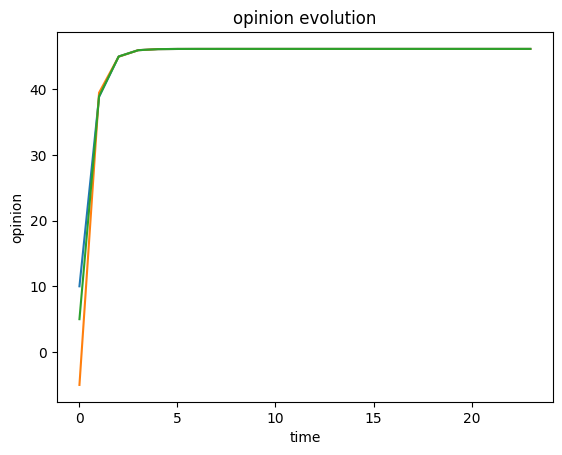

In [12]:
time_grid = range(len(xs))

for agent in range(3):
    plt.plot(time_grid, [xs[t][agent, 0] for t in time_grid])

plt.xlabel("time")
plt.ylabel("opinion")
plt.title("opinion evolution")
plt.show()

In [13]:
np.mean((xs[-1].T)[0])

46.104904985110124

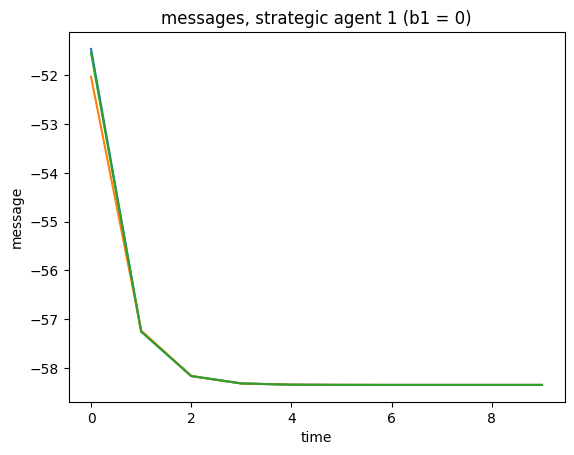

In [14]:
time_grid = range(10)
for agent in range(3):
    plt.plot(time_grid, [rs[0][t][agent, 0] for t in time_grid])

plt.xlabel("time")
plt.ylabel("message")
plt.title("messages, strategic agent 1 (b1 = 0)")
plt.show()

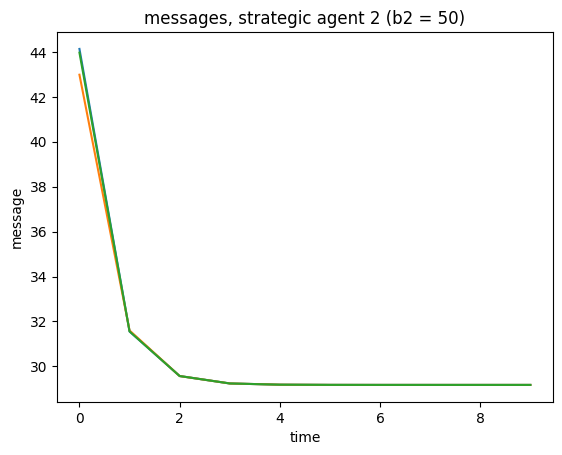

In [15]:
time_grid = range(10)
for agent in range(3):
    plt.plot(time_grid, [rs[1][t][agent, 0] for t in time_grid])

plt.xlabel("time")
plt.ylabel("message")
plt.title("messages, strategic agent 2 (b2 = 50)")
plt.show()

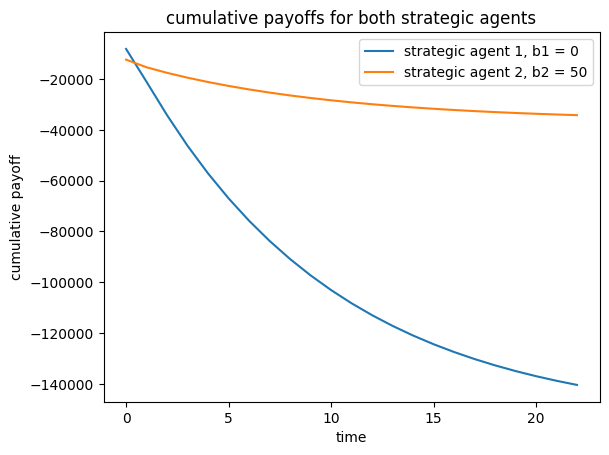

In [16]:
plt.plot(range(len(payoffs[0])), payoffs[0], label = "strategic agent 1, b1 = 0")
plt.plot(range(len(payoffs[1])), payoffs[1], label = "strategic agent 2, b2 = 50")
plt.xlabel("time")
plt.ylabel("cumulative payoff")
plt.title("cumulative payoffs for both strategic agents")
plt.legend()
plt.show()

In [17]:
# OPINIONS
for i, opinion_vec in enumerate(xs):
    print(f"t = {i}:", opinion_vec.T)

t = 0: [[10. -5.  5.]]
t = 1: [[38.80773435 39.4401674  38.89596377]]
t = 2: [[44.94922021 44.92476667 44.94771587]]
t = 3: [[45.9124875  45.91339861 45.91251119]]
t = 4: [[46.07322035 46.07318699 46.07322005]]
t = 5: [[46.09967503 46.09967624 46.09967503]]
t = 6: [[46.10404217 46.10404212 46.10404217]]
t = 7: [[46.10476262 46.10476263 46.10476262]]
t = 8: [[46.1048815 46.1048815 46.1048815]]
t = 9: [[46.10490111 46.10490111 46.10490111]]
t = 10: [[46.10490435 46.10490435 46.10490435]]
t = 11: [[46.10490488 46.10490488 46.10490488]]
t = 12: [[46.10490497 46.10490497 46.10490497]]
t = 13: [[46.10490498 46.10490498 46.10490498]]
t = 14: [[46.10490498 46.10490498 46.10490498]]
t = 15: [[46.10490499 46.10490499 46.10490499]]
t = 16: [[46.10490499 46.10490499 46.10490499]]
t = 17: [[46.10490499 46.10490499 46.10490499]]
t = 18: [[46.10490499 46.10490499 46.10490499]]
t = 19: [[46.10490499 46.10490499 46.10490499]]
t = 20: [[46.10490499 46.10490499 46.10490499]]
t = 21: [[46.10490499 46.1049

In [18]:
# MESSAGES
for i in range(len(rs[0])):
    print(f"t = {i}:")
    print("  strategic agent 1:", rs[0][i].T)
    print("  strategic agent 2:", rs[1][i].T)
    print()

t = 0:
  strategic agent 1: [[-51.45971918 -52.03091805 -51.54049283]]
  strategic agent 2: [[44.13372677 42.98554272 43.9682283 ]]

t = 1:
  strategic agent 1: [[-57.25359219 -57.23150825 -57.25218735]]
  strategic agent 2: [[31.55340653 31.59779257 31.55636341]]

t = 2:
  strategic agent 1: [[-58.16427247 -58.16509526 -58.16429566]]
  strategic agent 2: [[29.56896145 29.56730784 29.56890968]]

t = 3:
  strategic agent 1: [[-58.31615756 -58.31612743 -58.31615722]]
  strategic agent 2: [[29.23825824 29.23831879 29.23825911]]

t = 4:
  strategic agent 1: [[-58.34115859 -58.34115969 -58.3411586 ]]
  strategic agent 2: [[29.18381337 29.18381117 29.18381336]]

t = 5:
  strategic agent 1: [[-58.34528567 -58.34528563 -58.34528567]]
  strategic agent 2: [[29.17482616 29.17482624 29.17482616]]

t = 6:
  strategic agent 1: [[-58.34596653 -58.34596653 -58.34596653]]
  strategic agent 2: [[29.1733435 29.1733435 29.1733435]]

t = 7:
  strategic agent 1: [[-58.34607887 -58.34607887 -58.34607887]]
 

In [19]:
# CUMULATIVE PAYOFFS
print("        strategic agent 1  strategic agent 2")
for i in range(len(payoffs[0])):
    print(f"t = {i}:", payoffs[0][i], payoffs[1][i])

        strategic agent 1  strategic agent 2
t = 0: -8161.741532126131 -12378.74782131774
t = 1: -21126.867355398703 -15393.674494713567
t = 2: -34255.598786086935 -17580.401961165648
t = 3: -46303.25290172857 -19486.552130985485
t = 4: -57180.927881997246 -21193.29381069726
t = 5: -66976.00983772313 -22728.06532992689
t = 6: -75792.35218792183 -24109.167491555778
t = 7: -83727.17443829513 -25352.130901798082
t = 8: -90868.53141197604 -26470.793733895007
t = 9: -97295.75520499311 -27477.589653605322
t = 10: -103080.2569924201 -28383.70588791668
t = 11: -108286.30865659773 -29199.210484923562
t = 12: -112971.75516259794 -29933.16462016967
t = 13: -117188.65701922176 -30593.72334158526
t = 14: -120983.8686903649 -31188.226190813868
t = 15: -124399.55919442071 -31723.278755112868
t = 16: -127473.68064807495 -32204.826062980967
t = 17: -130240.38995636435 -32638.218640062107
t = 18: -132730.4283338249 -33028.271959435115
t = 19: -134971.46287353942 -33379.31994687082
t = 20: -136988.393959